In [151]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

from sklearn.linear_model import (
LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge,
SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, GammaRegressor,
PoissonRegressor, TweedieRegressor
)
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
HistGradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
)
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')


# Evaluation helper
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt

results = {}



In [152]:
def plot_model_results(name, y_test, y_pred):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel("Actual MEDV")
    plt.ylabel("Predicted MEDV")
    plt.title(f"{name} — Actual vs Predicted")
    plt.grid(True)

    # خط ایده‌آل (y = x)
    x_min, x_max = min(y_test), max(y_test)
    plt.plot([x_min, x_max], [x_min, x_max], 'r--', linewidth=2)

    plt.show()

In [153]:
scoring = {
'r2': 'r2',
'neg_mse': 'neg_mean_squared_error',
'neg_mae': 'neg_mean_absolute_error'
}




def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=5):
# fit   
    model.fit(X_train, y_train)
    # predict
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # cross-validate
    cv_res = cross_validate(model, np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)),
    cv=KFold(n_splits=cv, shuffle=True, random_state=42), scoring=scoring, return_train_score=False)
    cv_r2 = cv_res['test_r2']
    cv_rmse = np.sqrt(-cv_res['test_neg_mse'])
    cv_mae = -cv_res['test_neg_mae']

    print(f"--- {name} ---")
    print(f"Test : R2={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}")
    print(f"CV({cv}) : R2={cv_r2.mean():.4f} ± {cv_r2.std():.4f} | RMSE={cv_rmse.mean():.4f} ± {cv_rmse.std():.4f} | MAE={cv_mae.mean():.4f} ± {cv_mae.std():.4f}")
    print()

    results[name] = {
        "Test_R2": r2,
        "Test_RMSE": rmse,
        "Test_MAE": mae,
        "CV_R2_mean": cv_r2.mean(),
        "CV_R2_std": cv_r2.std(),
        "CV_RMSE_mean": cv_rmse.mean(),
        "CV_RMSE_std": cv_rmse.std(),
        "CV_MAE_mean": cv_mae.mean(),
        "CV_MAE_std": cv_mae.std()
    }

    
    plot_model_results(name, y_test, y_pred)

In [154]:
try:
    # scikit-learn deprecated load_boston; some versions may still have it
    from sklearn.datasets import load_boston
    b = load_boston()
    X = pd.DataFrame(b.data, columns=b.feature_names)
    y = pd.Series(b.target, name='MEDV')
    print('Loaded Boston from sklearn.datasets.load_boston')
except Exception:
    # fallback: openml
    from sklearn.datasets import fetch_openml
    b = fetch_openml(name='Boston', version=1, as_frame=True)
    df = b.frame.copy()
    # Many openml versions include target column named 'MEDV' or 'target'
    if 'MEDV' in df.columns:
        y = df['MEDV'].astype(float)
        X = df.drop(columns=['MEDV'])
    elif 'target' in df.columns:
        y = df['target'].astype(float)  
        X = df.drop(columns=['target'])
    else:
    # If not, assume last column is target
        y = df.iloc[:, -1].astype(float)
        X = df.iloc[:, :-1]
    print('Loaded Boston from OpenML')

Loaded Boston from OpenML


In [155]:
X_np = X.values
y_np = y.values


X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print('Train/Test sizes:', X_train.shape, X_test.shape)

Train/Test sizes: (404, 13) (102, 13)


--- LinearRegression ---
Test : R2=0.6688 | RMSE=4.9286 | MAE=3.1891
CV(5) : R2=0.7164 ± 0.0616 | RMSE=4.8552 ± 0.8345 | MAE=3.4034 ± 0.3162



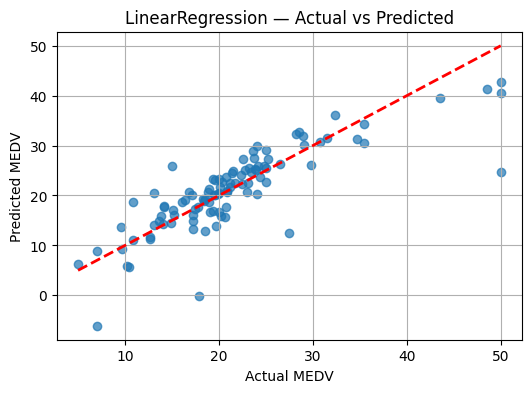

In [156]:
model = LinearRegression()
evaluate_model('LinearRegression', model, X_train, y_train, X_test, y_test)


--- Ridge ---
Test : R2=0.6685 | RMSE=4.9308 | MAE=3.1857
CV(5) : R2=0.7168 ± 0.0620 | RMSE=4.8518 ± 0.8387 | MAE=3.3961 ± 0.3185



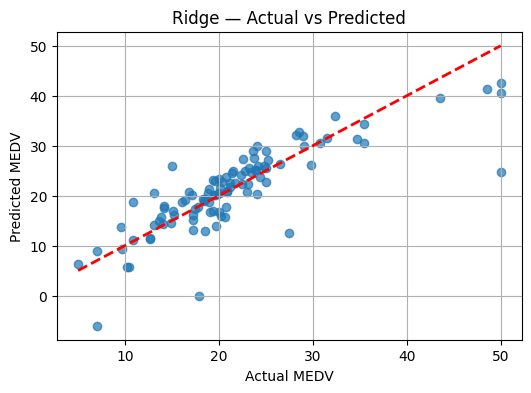

In [157]:
model = Ridge(alpha=1.0, random_state=42)
evaluate_model('Ridge', model, X_train, y_train, X_test, y_test)

--- Lasso ---
Test : R2=0.6682 | RMSE=4.9329 | MAE=3.1812
CV(5) : R2=0.7168 ± 0.0623 | RMSE=4.8518 ± 0.8407 | MAE=3.3919 ± 0.3193



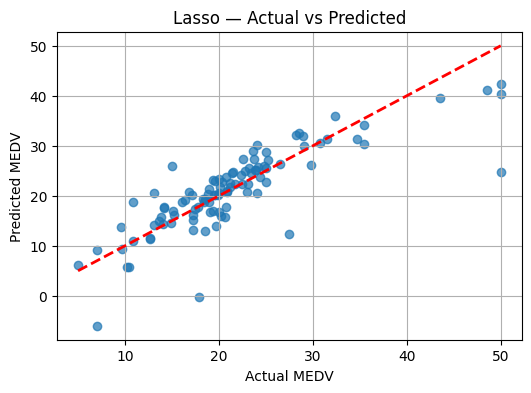

In [158]:
model = Lasso(alpha=0.01, random_state=42, max_iter=5000)
evaluate_model('Lasso', model, X_train, y_train, X_test, y_test)

In [159]:
model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=5000)
evaluate_model('ElasticNet', model, X_train, y_train, X_test, y_test)

--- ElasticNet ---
Test : R2=0.6679 | RMSE=4.9353 | MAE=3.1804
CV(5) : R2=0.7173 ± 0.0628 | RMSE=4.8477 ± 0.8458 | MAE=3.3848 ± 0.3223



--- BayesianRidge ---
Test : R2=0.6670 | RMSE=4.9414 | MAE=3.1766
CV(5) : R2=0.7179 ± 0.0638 | RMSE=4.8417 ± 0.8558 | MAE=3.3703 ± 0.3290



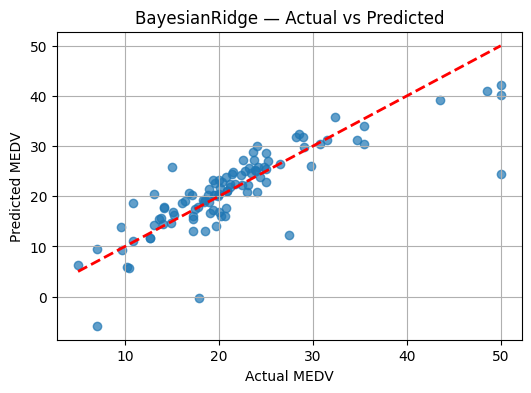

In [160]:
model = BayesianRidge()
evaluate_model('BayesianRidge', model, X_train, y_train, X_test, y_test)

In [161]:
model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
evaluate_model('SGDRegressor', model, X_train, y_train, X_test, y_test)

--- SGDRegressor ---
Test : R2=0.6608 | RMSE=4.9875 | MAE=3.2132
CV(5) : R2=0.7168 ± 0.0608 | RMSE=4.8521 ± 0.8274 | MAE=3.3794 ± 0.3312



In [162]:
#model = PassiveAggressiveRegressor(max_iter=1000, random_state=42)
#evaluate_model('PassiveAggressiveRegressor', model, X_train, y_train, X_test, y_test)

--- HuberRegressor ---
Test : R2=0.6147 | RMSE=5.3155 | MAE=3.1082
CV(5) : R2=0.7078 ± 0.0957 | RMSE=4.9113 ± 1.1157 | MAE=3.1982 ± 0.4417



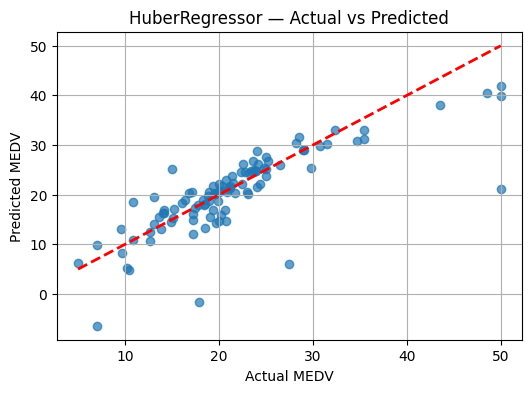

In [163]:
model = HuberRegressor(max_iter=1000)
evaluate_model('HuberRegressor', model, X_train, y_train, X_test, y_test)

--- SVR (RBF) ---
Test : R2=0.6500 | RMSE=5.0664 | MAE=2.7317
CV(5) : R2=0.6590 ± 0.1001 | RMSE=5.3228 ± 1.1474 | MAE=3.1511 ± 0.4873



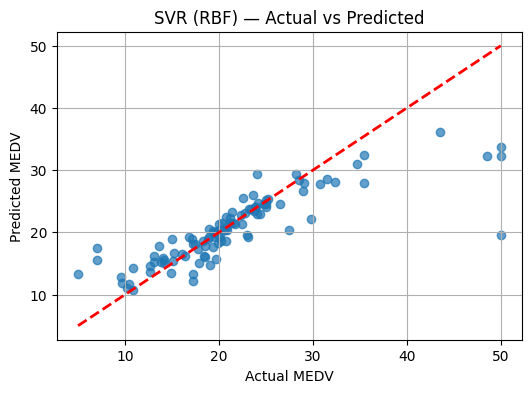

In [164]:
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
evaluate_model('SVR (RBF)', model, X_train, y_train, X_test, y_test)

In [165]:
#model = KernelRidge(alpha=1.0)
#evaluate_model('KernelRidge', model, X_train, y_train, X_test, y_test)

--- KNeighborsRegressor ---
Test : R2=0.7190 | RMSE=4.5393 | MAE=2.5922
CV(5) : R2=0.7475 ± 0.1014 | RMSE=4.5133 ± 1.1556 | MAE=2.8930 ± 0.4959



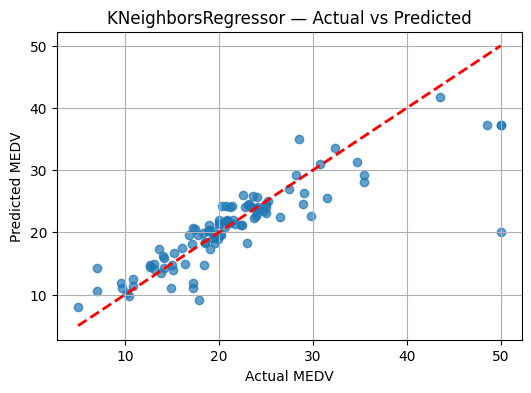

In [166]:
model = KNeighborsRegressor(n_neighbors=5)
evaluate_model('KNeighborsRegressor', model, X_train, y_train, X_test, y_test)

--- DecisionTreeRegressor ---
Test : R2=0.8580 | RMSE=3.2274 | MAE=2.3941
CV(5) : R2=0.7602 ± 0.0719 | RMSE=4.4452 ± 0.9121 | MAE=3.1410 ± 0.4051



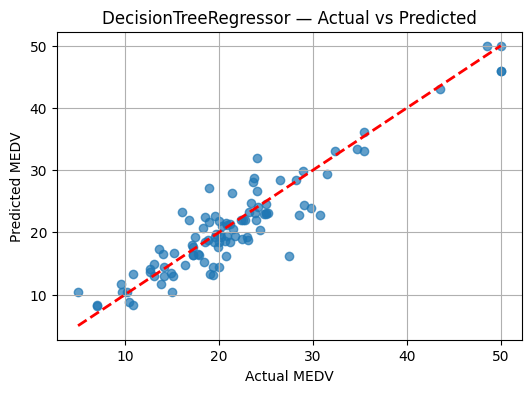

In [167]:
model = DecisionTreeRegressor(random_state=42)
evaluate_model('DecisionTreeRegressor', model, X_train, y_train, X_test, y_test)

--- RandomForestRegressor ---
Test : R2=0.8839 | RMSE=2.9180 | MAE=2.0422
CV(5) : R2=0.8574 ± 0.0647 | RMSE=3.4228 ± 0.9871 | MAE=2.3039 ± 0.4412



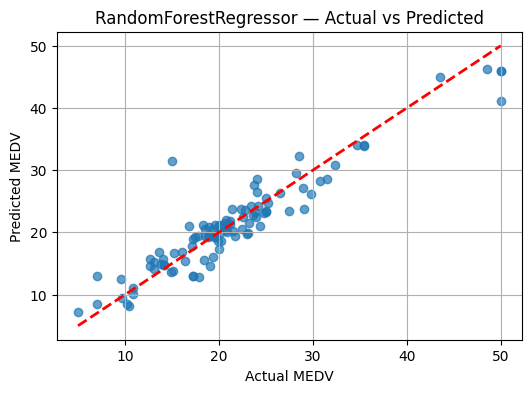

In [168]:
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
evaluate_model('RandomForestRegressor', model, X_train, y_train, X_test, y_test)

--- ExtraTreesRegressor ---
Test : R2=0.8691 | RMSE=3.0984 | MAE=1.9555
CV(5) : R2=0.8900 ± 0.0462 | RMSE=3.0079 ± 0.8204 | MAE=2.0610 ± 0.3144



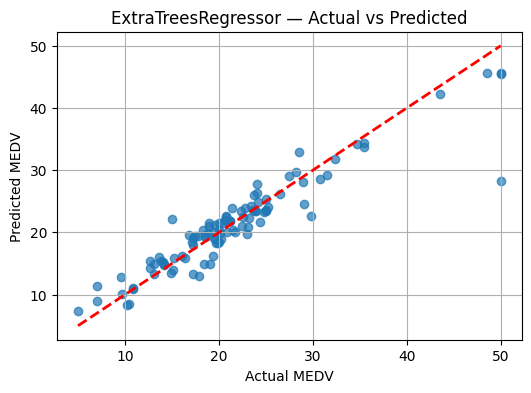

In [169]:
model = ExtraTreesRegressor(n_estimators=200, random_state=42, n_jobs=-1)
evaluate_model('ExtraTreesRegressor', model, X_train, y_train, X_test, y_test)

--- GradientBoostingRegressor ---
Test : R2=0.9162 | RMSE=2.4797 | MAE=1.8919
CV(5) : R2=0.8856 ± 0.0397 | RMSE=3.0787 ± 0.7678 | MAE=2.1083 ± 0.2994



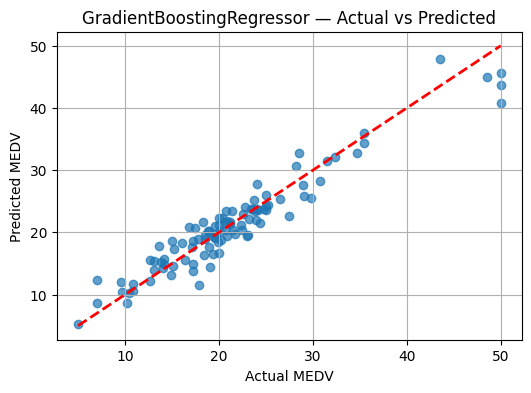

In [170]:
model = GradientBoostingRegressor(n_estimators=200, random_state=42)
evaluate_model('GradientBoostingRegressor', model, X_train, y_train, X_test, y_test)

--- HistGradientBoostingRegressor ---
Test : R2=0.8795 | RMSE=2.9731 | MAE=2.0347
CV(5) : R2=0.8626 ± 0.0648 | RMSE=3.3421 ± 1.0089 | MAE=2.3064 ± 0.5102



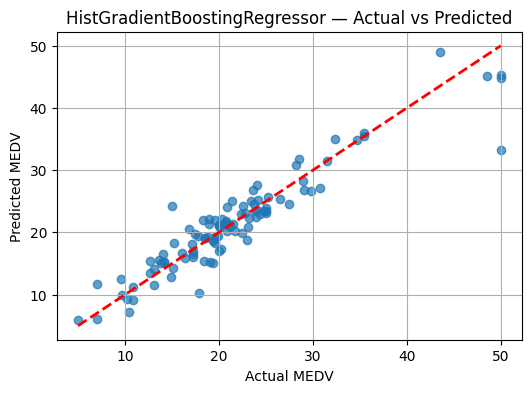

In [171]:
model = HistGradientBoostingRegressor(max_iter=200, random_state=42)
evaluate_model('HistGradientBoostingRegressor', model, X_train, y_train, X_test, y_test)

--- AdaBoostRegressor ---
Test : R2=0.8407 | RMSE=3.4184 | MAE=2.4670
CV(5) : R2=0.8169 ± 0.0604 | RMSE=3.8891 ± 0.8673 | MAE=2.8295 ± 0.3477



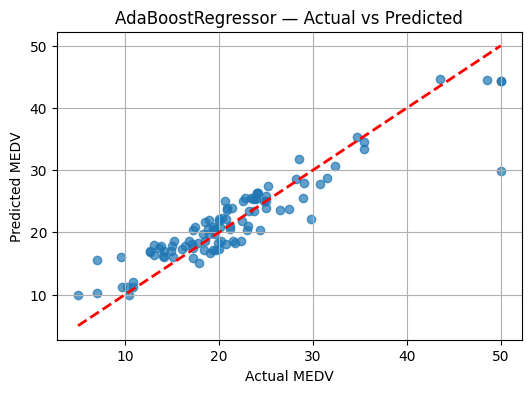

In [172]:
model = AdaBoostRegressor(n_estimators=100, random_state=42)
evaluate_model('AdaBoostRegressor', model, X_train, y_train, X_test, y_test)

--- BaggingRegressor ---
Test : R2=0.8917 | RMSE=2.8178 | MAE=2.0412
CV(5) : R2=0.8536 ± 0.0649 | RMSE=3.4676 ± 0.9743 | MAE=2.3024 ± 0.4418



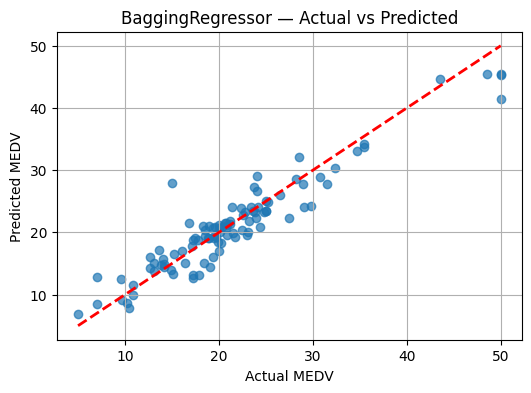

In [173]:
model = BaggingRegressor(n_estimators=50, random_state=42)
evaluate_model('BaggingRegressor', model, X_train, y_train, X_test, y_test)

--- MLPRegressor ---
Test : R2=0.8079 | RMSE=3.7534 | MAE=2.3626
CV(5) : R2=0.8333 ± 0.0438 | RMSE=3.7289 ± 0.7528 | MAE=2.6065 ± 0.3193



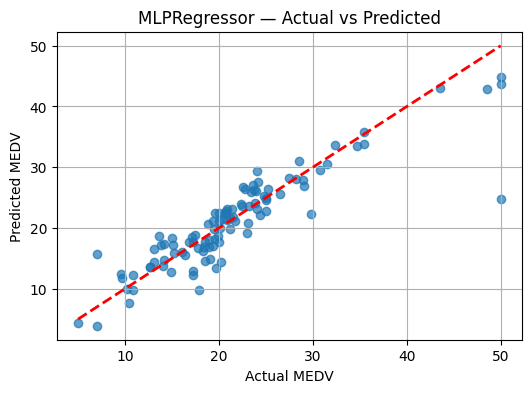

In [174]:
model = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=1000, random_state=42)
evaluate_model('MLPRegressor', model, X_train, y_train, X_test, y_test)

--- GammaRegressor ---
Test : R2=0.6432 | RMSE=5.1153 | MAE=3.1651
CV(5) : R2=0.6355 ± 0.1127 | RMSE=5.4919 ± 1.2022 | MAE=3.6772 ± 0.4175



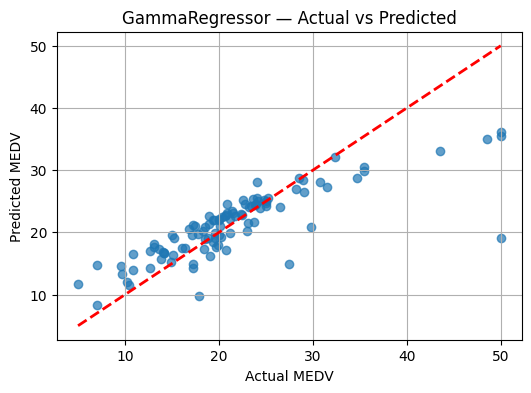

In [175]:
model = GammaRegressor(max_iter=1000)
evaluate_model('GammaRegressor', model, X_train, y_train, X_test, y_test)

--- PoissonRegressor ---
Test : R2=0.7643 | RMSE=4.1578 | MAE=2.6426
CV(5) : R2=0.7801 ± 0.0692 | RMSE=4.2618 ± 0.9436 | MAE=2.8979 ± 0.2966



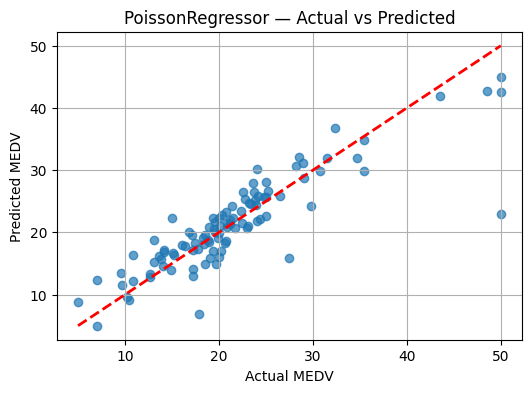

In [176]:
model = PoissonRegressor(max_iter=1000)
evaluate_model('PoissonRegressor', model, X_train, y_train, X_test, y_test)

--- TweedieRegressor ---
Test : R2=0.6132 | RMSE=5.3261 | MAE=3.4092
CV(5) : R2=0.6267 ± 0.1004 | RMSE=5.5649 ± 1.1037 | MAE=3.8501 ± 0.3882



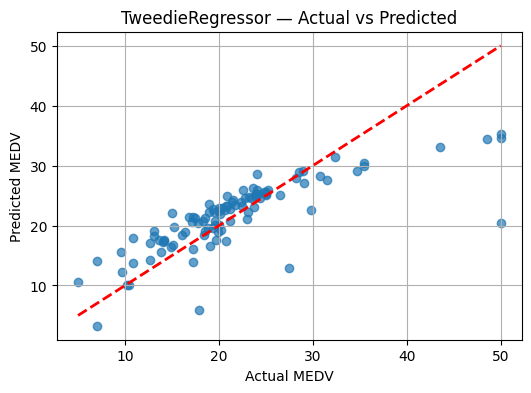

In [177]:
model = TweedieRegressor(power=0, max_iter=1000)
evaluate_model('TweedieRegressor', model, X_train, y_train, X_test, y_test)

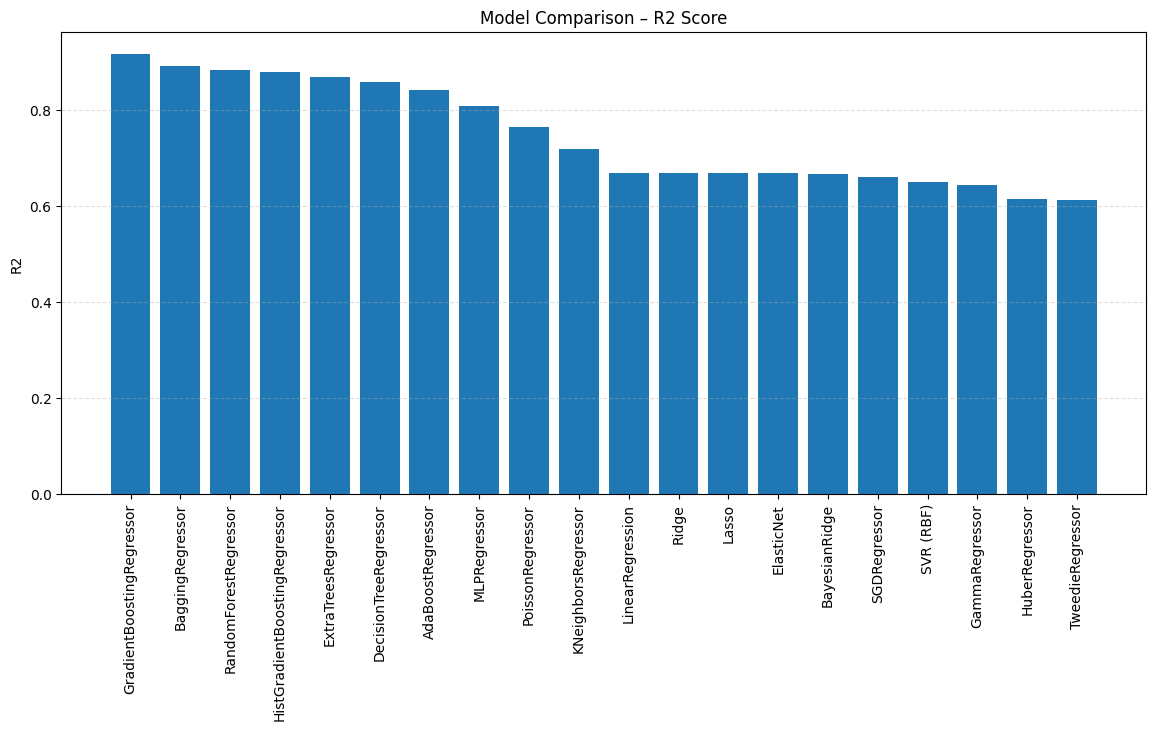

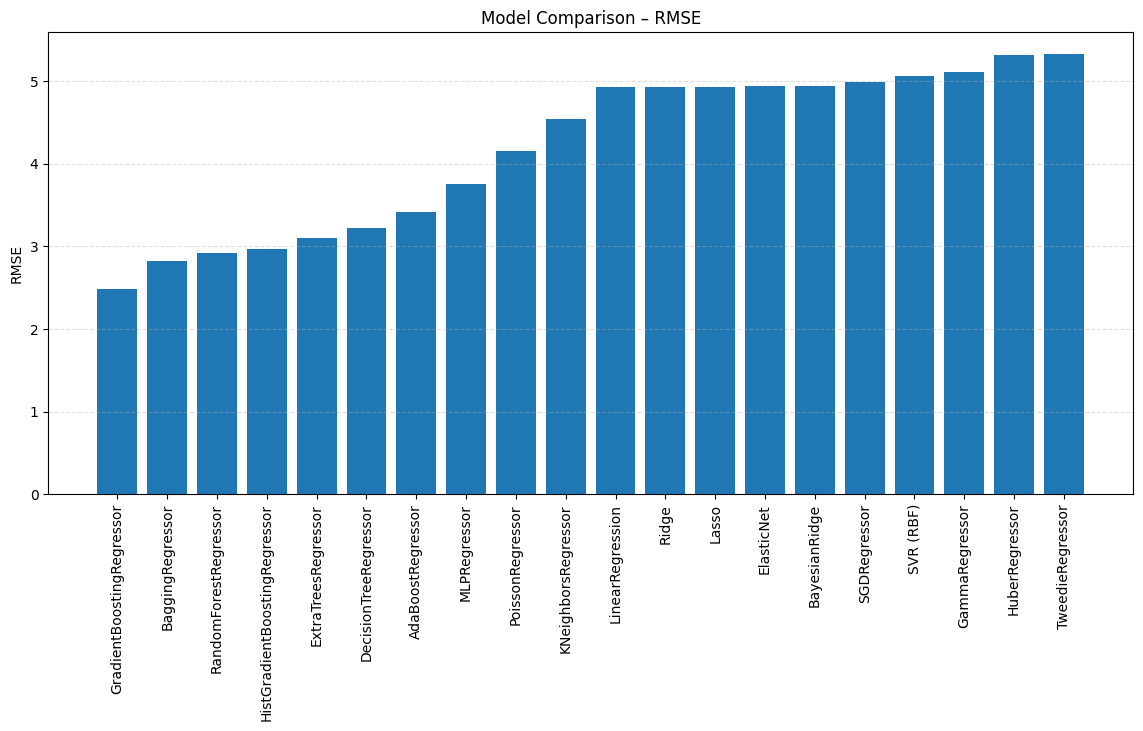

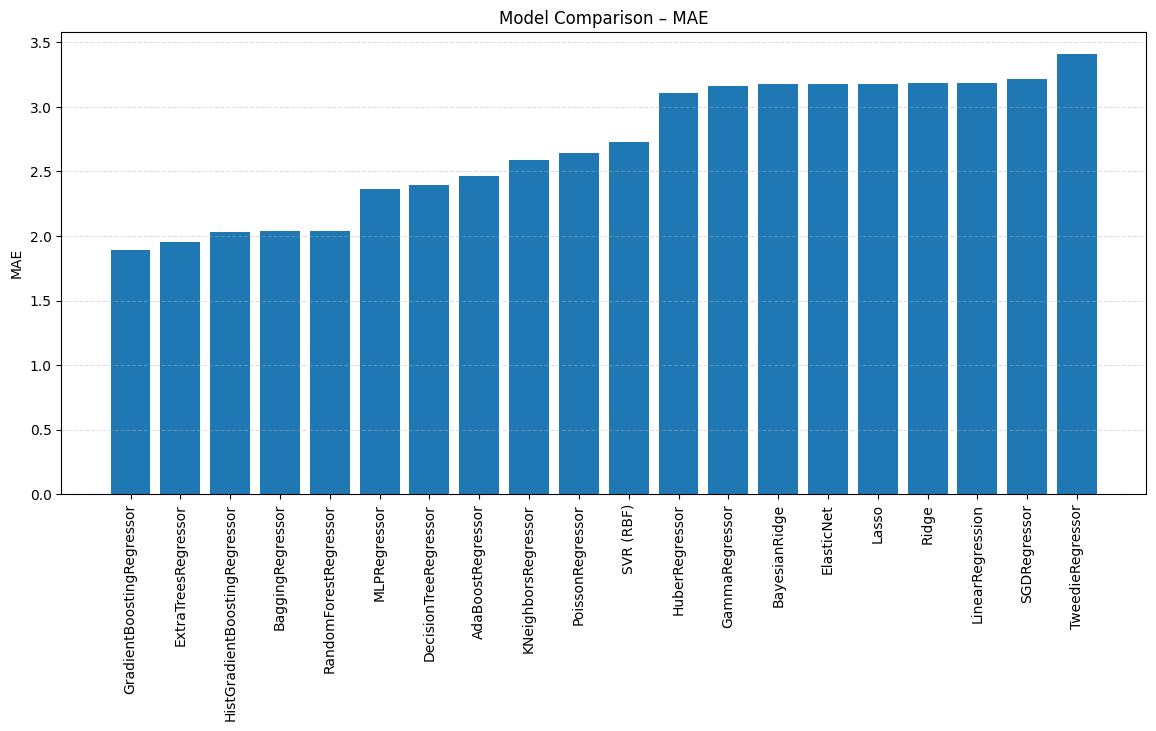

In [178]:
df_results = pd.DataFrame(results).T

# مرتب‌سازی پیش‌فرض بر اساس R2
df_sorted_r2 = df_results.sort_values("Test_R2", ascending=False)
df_sorted_rmse = df_results.sort_values("Test_RMSE", ascending=True)
df_sorted_mae = df_results.sort_values("Test_MAE", ascending=True)

# ----- R2 -----
plt.figure(figsize=(14, 6))
plt.bar(df_sorted_r2.index, df_sorted_r2["Test_R2"])
plt.title("Model Comparison – R2 Score")
plt.ylabel("R2")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# ----- RMSE -----
plt.figure(figsize=(14, 6))
plt.bar(df_sorted_rmse.index, df_sorted_rmse["Test_RMSE"])
plt.title("Model Comparison – RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# ----- MAE -----
plt.figure(figsize=(14, 6))
plt.bar(df_sorted_mae.index, df_sorted_mae["Test_MAE"])
plt.title("Model Comparison – MAE")
plt.ylabel("MAE")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()
